# Machine failure prediction

## Introduction

In the field of industrial maintenance and operations, the timely detection of machine failures is crucial to prevent unexpected downtime, minimize production losses, and optimize maintenance strategies. Machine learning techniques have emerged as valuable tools for predicting and classifying data. However, the effectiveness of such models heavily relies on the quality and balance of the dataset used for training.

Throughout this project, I will explore different techniques for addressing class imbalance, including oversampling and undersampling methods, such as Synthetic Minority Over-sampling Technique (SMOTE) and Random Under-Sampling (RUS). Additionally, I will investigate the impact of various feature engineering strategies, such as dimensionality reduction and feature selection, to improve the model's ability to discriminate between healthy and failing machines.

The performance of the developed binary classification models will be evaluated using accuracy, consufion matrix and area under the receiver operating characteristic curve (AUC-ROC). The results will be compared with a baseline model trained on the original unbalanced dataset, highlighting the effectiveness of the proposed techniques in improving the model's performance on the minority class (failure machines).

## Loading the train data uploaded to Databricks previously

In [0]:
# File location and type
file_location = "/FileStore/tables/train.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df.limit(10))

id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
5,M24300,M,298.4,308.9,1429,42.1,65,0,0,0,0,0,0
6,L56736,L,299.6,311.0,1413,42.9,156,0,0,0,0,0,0
7,L55488,L,298.7,310.1,1609,38.1,67,0,0,0,0,0,0
8,L56397,L,297.7,308.8,1578,35.2,13,0,0,0,0,0,0
9,L55067,L,300.5,312.3,1447,53.3,98,0,0,0,0,0,0


### Standardization of columns name

In [0]:
from pyspark.sql.functions import regexp_replace, col

# Rename columns with spaces to columns with underscores
df = df.withColumnRenamed("Product Id", "product_id")\
        .withColumnRenamed("Air temperature [K]", "air_temperature")\
        .withColumnRenamed("Process temperature [K]", "process_temperature")\
        .withColumnRenamed("Rotational speed [rpm]", "rotational_speed")\
        .withColumnRenamed("Torque [Nm]", "torque")\
        .withColumnRenamed("Tool wear [min]", "tool_wear")\
        .withColumnRenamed("machine failure", "machine_failure")

# Lower all columns name
df = df.select([c.lower() for c in df.columns])

# Remove unwanted characters from columns name
df = df.select([regexp_replace(col(c), "[ ,;{}()\n\t=]", "").alias(c) for c in df.columns])
display(df.limit(10))    

id,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
5,M24300,M,298.4,308.9,1429,42.1,65,0,0,0,0,0,0
6,L56736,L,299.6,311.0,1413,42.9,156,0,0,0,0,0,0
7,L55488,L,298.7,310.1,1609,38.1,67,0,0,0,0,0,0
8,L56397,L,297.7,308.8,1578,35.2,13,0,0,0,0,0,0
9,L55067,L,300.5,312.3,1447,53.3,98,0,0,0,0,0,0


### Saving data

In [0]:
# Save table

permanent_table_name = "train_csv"

df.write.mode("overwrite").format("csv")\
    .option("path", "/tables")\
    .saveAsTable(permanent_table_name)

In [0]:
# Check if table exists
dbutils.fs.ls("./tables")

Out[194]: [FileInfo(path='dbfs:/tables/Ij/', name='Ij/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/tables/JF/', name='JF/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/tables/K1/', name='K1/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/tables/_committed_6145017237376570438', name='_committed_6145017237376570438', size=200, modificationTime=1689621015000),
 FileInfo(path='dbfs:/tables/_committed_6258123779101392580', name='_committed_6258123779101392580', size=1357, modificationTime=1689631145000),
 FileInfo(path='dbfs:/tables/_committed_7887710260095400243', name='_committed_7887710260095400243', size=526, modificationTime=1689621297000),
 FileInfo(path='dbfs:/tables/_committed_vacuum5573514736145143151', name='_committed_vacuum5573514736145143151', size=96, modificationTime=1689631148000),
 FileInfo(path='dbfs:/tables/_delta_log/', name='_delta_log/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/tables/_started_6258123779101392580', name='_started_6258123

## Exploratory Data Analysis

### Loading the table using Apache Spark SQL

In [0]:
%sql

CREATE OR REPLACE TABLE train
USING DELTA LOCATION "/tables"
--TBLPROPERTIES ('delta.columnMapping.mode' = 'name')
AS (
  SELECT
    first(type) AS type,
    first(machine_failure) AS machine_failure,
    MAX(CAST(air_temperature AS INT)) AS max_air_temperature,
    MIN(CAST(air_temperature AS INT)) AS min_air_temperature,
    AVG(CAST(air_temperature AS INT)) AS avg_air_temperature,
    MAX(CAST(process_temperature AS INT)) AS max_process_temperature,
    MIN(CAST(process_temperature AS INT)) AS min_process_temperature,
    AVG(CAST(process_temperature AS INT)) AS avg_process_temperature,
    MAX(CAST(rotational_speed AS INT)) AS max_rotational_speed,
    MIN(CAST(rotational_speed AS INT)) AS min_rotational_speed,
    AVG(CAST(rotational_speed AS INT)) AS avg_rotational_speed,
    MAX(CAST(torque AS INT)) AS max_torque,
    MIN(CAST(torque AS INT)) AS min_torque,
    AVG(CAST(torque AS INT)) AS avg_torque,
    MAX(CAST(tool_wear AS INT)) AS max_tool_wear,
    MIN(CAST(tool_wear AS INT)) AS min_tool_wear,
    AVG(CAST(tool_wear AS INT)) AS avg_tool_wear
  FROM train_csv
  GROUP BY product_id
)


num_affected_rows,num_inserted_rows


**Using the DESCRIBE function to output table details such as data type**

In [0]:
%sql
DESCRIBE EXTENDED train

col_name,data_type,comment
type,string,null
machine_failure,string,null
max_air_temperature,int,null
min_air_temperature,int,null
avg_air_temperature,double,null
max_process_temperature,int,null
min_process_temperature,int,null
avg_process_temperature,double,null
max_rotational_speed,int,null
min_rotational_speed,int,null


In [0]:
%sql

SELECT * 
FROM train
LIMIT 10


type,machine_failure,max_air_temperature,min_air_temperature,avg_air_temperature,max_process_temperature,min_process_temperature,avg_process_temperature,max_rotational_speed,min_rotational_speed,avg_rotational_speed,max_torque,min_torque,avg_torque,max_tool_wear,min_tool_wear,avg_tool_wear
H,0,298,298,298.0,309,309,309.0,1487,1487,1487.0,36,36,36.0,35,35,35.0
H,0,298,298,298.0,309,308,308.75,1522,1412,1445.0,60,34,44.5,33,16,26.75
H,0,298,298,298.0,309,309,309.0,1436,1306,1349.3333333333333,54,54,54.0,203,21,91.33333333333333
H,0,298,298,298.0,309,309,309.0,1393,1393,1393.0,52,52,52.0,167,167,167.0
H,0,299,298,298.6,309,308,308.6,1678,1379,1514.8,49,24,33.0,208,0,116.8
H,0,299,297,298.125,309,308,308.75,1834,1339,1533.375,51,23,39.5,134,0,82.125
H,0,298,298,298.0,309,309,309.0,1466,1397,1431.5,44,44,44.0,179,120,149.5
H,0,298,298,298.0,309,308,308.8888888888889,2449,1369,1606.6666666666667,53,13,38.888888888888886,200,0,116.66666666666667
H,0,298,298,298.0,309,308,308.3333333333333,1457,1436,1446.3333333333333,44,43,43.333333333333336,147,2,68.33333333333333
H,0,298,298,298.0,308,308,308.0,1611,1368,1460.3333333333333,47,33,42.333333333333336,127,14,78.83333333333333


In [0]:
%sql

-- plot total by machine type
SELECT type, count(*) AS total
FROM train
GROUP BY type

type,total
L,5995
M,2985
H,996


Databricks visualization. Run in Databricks to view.

This plot displays the distribution of machine types based on the total number of machines. Ideally, we aim for a relatively balanced distribution across all machine types. Having a similar number of machines for each type ensures that our model is not biased or overly influenced by the machine type feature.

In [0]:
%sql 

-- plot total by machine status (failure or not)
SELECT type, machine_failure, count(*) AS total
FROM train
GROUP BY type, machine_failure

type,machine_failure,total
M,1,39
L,0,5883
H,0,984
H,1,12
L,1,112
M,0,2946


Databricks visualization. Run in Databricks to view.

This plot reveals an important insight: the failure percentage does not exceed 2% for any machine type. This information indicates that our dataset is unbalanced, as there is a significant difference in the failure occurrences across machine types. From a modeling perspective, it is crucial to address this class imbalance issue to ensure that it does not adversely impact the model's performance.

## Modeling

**Benchmark Model**

In [0]:
# read table 
df = spark.table("train").toPandas()
df.head(5)

,type,machine_failure,max_air_temperature,min_air_temperature,avg_air_temperature,max_process_temperature,min_process_temperature,avg_process_temperature,max_rotational_speed,min_rotational_speed,avg_rotational_speed,max_torque,min_torque,avg_torque,max_tool_wear,min_tool_wear,avg_tool_wear
0,H,0,298,298,298.0,309,309,309.00,1487,1487,1487.000000,36,36,36.0,35,35,35.000000
1,H,0,298,298,298.0,309,308,308.75,1522,1412,1445.000000,60,34,44.5,33,16,26.750000
2,H,0,298,298,298.0,309,309,309.00,1436,1306,1349.333333,54,54,54.0,203,21,91.333333
3,H,0,298,298,298.0,309,309,309.00,1393,1393,1393.000000,52,52,52.0,167,167,167.000000
4,H,0,299,298,298.6,309,308,308.60,1678,1379,1514.800000,49,24,33.0,208,0,116.800000


In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer


X = df.drop("machine_failure", axis=1)
y = df["machine_failure"]

# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

# Preprocess categorical and numerical features separately
categorical_features = ['type']
numerical_features = df.drop(["type", "machine_failure"], axis=1).columns

# Create transformers for each feature type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Create a pipeline
benchmark = make_pipeline(preprocessor, LogisticRegression())

# Fit the pipeline to the train set
benchmark.fit(X_train, y_train)

# Predict the validation set
y_predicted = benchmark.predict(X_val)

# Compute the accuracy score in the validation set
print(accuracy_score(y_val, y_predicted))

0.9839679358717435


The accuracy value achieved is remarkably high, with nearly 100% correct predictions. However, it is crucial to address a significant issue that has been mentioned previously. The dataset suffers from a severe class imbalance, with 98% of cases representing non-failure instances. Consequently, our model might struggle to identify failure cases effectively, as there is a 98% chance that simply predicting that a machine is not failing would yield correct results by chance. Now let's look to the AUC ROC curve and the confusion matrix as these metrics can shows a more accurate result.

To gain a more comprehensive understanding of our model's performance, it is recommended to use metrics such as the AUC ROC curve and the confusion matrix. These metrics provide a more accurate assessment of the model's predictive ability, particularly in scenarios with imbalanced datasets. By examining these metrics, we can better evaluate how well our model distinguishes between failure and non-failure cases.

Out[202]: <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7fc35775f2e0>

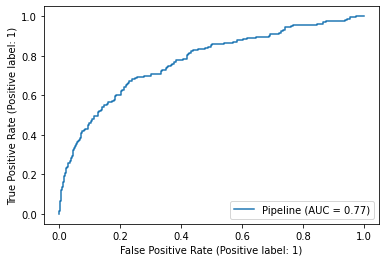

In [0]:
RocCurveDisplay.from_estimator(benchmark, X, y)

Oops! It appears that the AUC ROC curve reveals a different story compared to the initially high accuracy. The plot indicates that our model's performance is not as impressive as the accuracy metric initially suggested. In fact, the AUC ROC curve indicates that our model was able to correctly classify only 77% of the cases. Now let's use the confusion matrix to further investigate what is happening with our model's performance.

Out[203]: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fc35b7558b0>

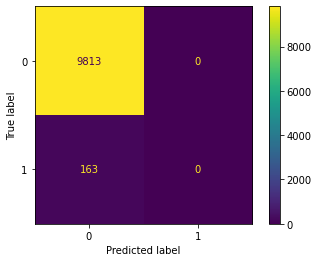

In [0]:
ConfusionMatrixDisplay.from_estimator(benchmark, X, y)

Finally, we have uncovered the truth about our model's performance. Upon closer examination, it becomes evident that our model excelled in classifying non-failure machines. However, when it comes to identifying failure cases, our model fared poorly, failing to correctly classify even a single instance of failure machines.

It is imperative to address the significant imbalance between failure and non-failure cases in our dataset, as any misclassification could have severe consequences. We must now focus on improving our model's ability to accurately identify and classify failure instances, as it is a critical aspect of our application.

Continues...